In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.mdp.overcooked_trajectory import DEFAULT_TRAJ_KEYS
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv, OvercookedGridworld
from overcooked_ai_py.agents.agent import *

In [21]:
def simulate_n_rooms(n_rooms, steps, agents=None):
    combined_trajectories = {k: [] for k in DEFAULT_TRAJ_KEYS}

    default_agents = agents is None

    # Prepare rooms and agents
    mdps = []
    envs = []
    trajs = []
    for j in range(n_rooms):
        mdp = OvercookedGridworld.from_layout_name("cramped_room_single")
        mdps.append(mdp)
        env = OvercookedEnv.from_mdp(mdp, horizon=steps)
        envs.append(env)
        trajs.append([])


    if default_agents:
        agents = [AgentGroup(GreedyHumanModelSingle(envs[0].mlam)),
                  AgentGroup(GreedyHumanModelSingle(envs[1].mlam, False, True, 1, 1))]
        
    # Contains the index of the appropriate agent for room i at index i
    agent_mapping = list(range(len(agents)))

    # Prepare agents
    for i in range(n_rooms):
        agents[i].set_mdp(mdps[i])

    # Simulate for n steps
    for i in range(steps):
        for j, env in enumerate(envs):
            state = env.state
            joint_action_and_infos = agents[agent_mapping[j]].joint_action(state)
            action, action_info = zip(*joint_action_and_infos)
            assert all(a in Action.ALL_ACTIONS for a in action)
            assert all(type(a_info) is dict for a_info in action_info)

            new_state, reward, done, info = env.step(action, action_info)
            trajs[j].append((state, action, reward, done, info))

            # Evaluate each agent for switching
            if i > 500:
                # Switch agents
                agent_idx = 1
                room_idx = 0
                agent_mapping[room_idx] = agent_idx
                agents[agent_idx].set_env(envs[room_idx])

                agent_idx = 0
                room_idx = 1
                agent_mapping[room_idx] = agent_idx
                agents[agent_idx].set_env(envs[room_idx])

    # Prepare data for visualization
    for j in range(n_rooms):
        trajectory = np.array(trajs[j], dtype=object)
        time_taken = envs[j].state.timestep
        total_sparse_reward = sum(envs[j].game_stats["cumulative_sparse_rewards_by_agent"])
        total_shaped_reward = sum(envs[j].game_stats["cumulative_shaped_rewards_by_agent"])

        rollout_info = (trajectory, time_taken, total_sparse_reward, total_shaped_reward)

        obs, actions, rews, dones, infos = (
            trajectory.T[0],
            trajectory.T[1],
            trajectory.T[2],
            trajectory.T[3],
            trajectory.T[4],
        )
        combined_trajectories["ep_states"].append(obs)
        combined_trajectories["ep_actions"].append(actions)
        combined_trajectories["ep_rewards"].append(rews)
        combined_trajectories["ep_dones"].append(dones)
        combined_trajectories["ep_infos"].append(infos)
        combined_trajectories["ep_returns"].append(total_sparse_reward)
        combined_trajectories["ep_lengths"].append(time_taken)
        combined_trajectories["mdp_params"].append(envs[j].mdp.mdp_params)
        combined_trajectories["env_params"].append(envs[j].env_params)
        # combined_trajectories["metadatas"].append(metadata_fn(rollout_info))

    return combined_trajectories

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reward(trajs, idx=None):
    if idx is None:
        idx = list(range(len(trajs['ep_rewards'])))
    if type(idx) is not list:
        idx = [idx]

    for i in idx:
        cum_reward = np.cumsum(trajs['ep_rewards'][i])
        plt.plot(cum_reward, label=f"Room {i+1}")

    plt.axvline(x=500, color='r', label='Agent Switch')
    plt.xlabel('Timestep')
    plt.ylabel('Cumulative Reward')
    plt.title('Reward over Time')
    plt.legend(loc='upper left')
    plt.show()

Computing MediumLevelActionManager
Computing MediumLevelActionManager


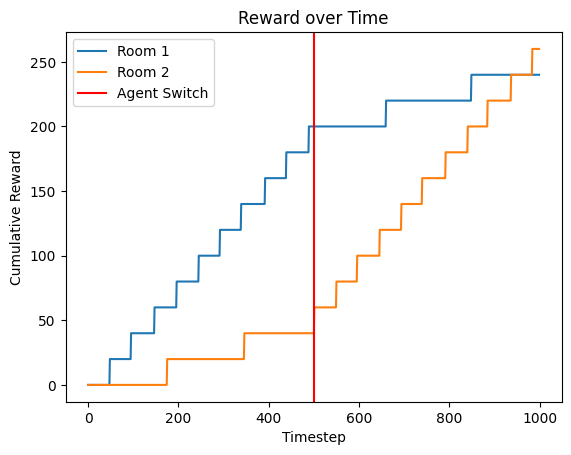

interactive(children=(IntSlider(value=0, description='timestep', max=999), Output()), _dom_classes=('widget-in…

interactive(children=(IntSlider(value=0, description='timestep', max=999), Output()), _dom_classes=('widget-in…

In [23]:
trajs = simulate_n_rooms(2, 1000)
plot_reward(trajs)
StateVisualizer().display_rendered_trajectory(trajs, 0, ipython_display=True)
StateVisualizer().display_rendered_trajectory(trajs, 1, ipython_display=True)